In [2]:
using ApproxFun, SingularIntegralEquations, RiemannHilbert, Plots, QuadGK, DualNumbers, ComplexPhasePortrait, LinearAlgebra
import ApproxFunBase: SequenceSpace, BasisFunctional, ℓ⁰, SpaceOperator, piece, pieces, npieces
import ApproxFunOrthogonalPolynomials: Recurrence 
import RiemannHilbert: RiemannDual, logpart, finitepart, istieltjes, LogNumber
import SingularIntegralEquations: ⁺, ⁻

# Riemann–Hilbert problems

Sheehan Olver
<br>
_Imperial College_

## RiemannHilbert.jl

An in-development package for solving Riemann–Hilbert problems, that builds on ApproxFun.jl and SingularIntegralEquations.jl.

Here's an example of calculating the Hastings–McLeod solution. This has the following contour:

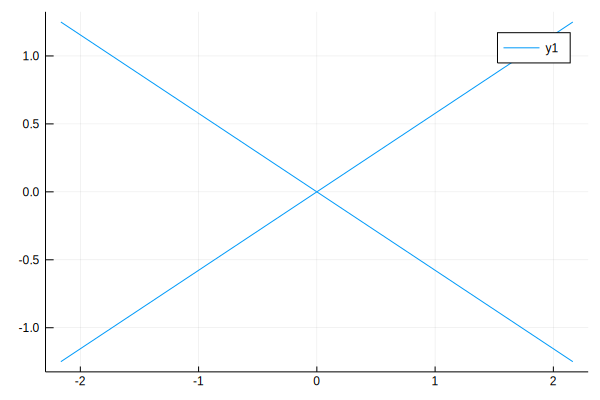

In [3]:
Γ = Segment(0, 2.5exp(im*π/6))   ∪ 
    Segment(0, 2.5exp(5im*π/6))  ∪
    Segment(0, 2.5exp(-5im*π/6)) ∪ 
    Segment(0, 2.5exp(-im*π/6))

plot(Γ)

We now define the jump:

In [4]:
s₁ = im
s₃ = -im

G = Fun( z -> if angle(z) ≈ π/6
                    [1                 0; 
                     s₁*exp(8im/3*z^3) 1]
                elseif angle(z) ≈ 5π/6
                    [1                 0; 
                     s₃*exp(8im/3*z^3) 1]
                elseif angle(z) ≈ -π/6
                    [1                -s₃*exp(-8im/3*z^3); 
                     0                 1]
                elseif angle(z) ≈ -5π/6
                    [1                -s₁*exp(-8im/3*z^3); 
                     0                 1]
                end
                    , Γ);

We can now solve the Riemann–Hilbert problem. The default is to solve $\Phi_+ = G \Phi_-$, so we transpose twice:

In [8]:
Φ = transpose(rhsolve(transpose(G), 800));

In [9]:
Φ(100.0)

2×2 Array{Complex{Float64},2}:
         1.0-0.000345453im  -0.00183531+6.75051e-6im 
 -0.00183531-6.75051e-6im           1.0+0.000345453im

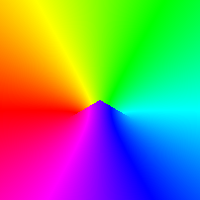

In [10]:
xx = range(-3.5,3.5,length=200)
Z = Φ[1,2].(xx' .+ im.*xx)
portrait(Z)

In [11]:
ζ = exp(im*π/6)
Φ((ζ)⁺) - Φ((ζ)⁻)*G(ζ) |> norm

8.263986678835547e-16

To recover Painleve II, we actually want the limit:

In [12]:
10000.0Φ(10000.0)

2×2 Array{Complex{Float64},2}:
   10000.0-0.0345457im   -0.183531+6.75028e-6im
 -0.183531-6.75028e-6im    10000.0+0.0345457im 

In [13]:
z = Fun(ℂ)
2(z*Φ[1,2])(Inf)

-0.36706155154807807 - 6.938893903907228e-17im

## Stieltjes transforms, Cauchy transforms, Riemann–Hilbert problems and singular integral equations


The Stieltjes transform is defined via
$$
    {\cal S}_\Gamma f(z) = \int_\Gamma {f(\zeta) \over z - \zeta} {\rm d} \zeta
$$
And the Cauchy transform is
$$
    {\cal C}_\Gamma f(z) = -{1 \over 2 \pi {\rm i}} {\cal S}_\Gamma(z)
$$

The solution is given by
$$
\Phi(z) = I + {\cal S}_\Gamma U(z)
$$ for some $U$ defined on $\Gamma$:

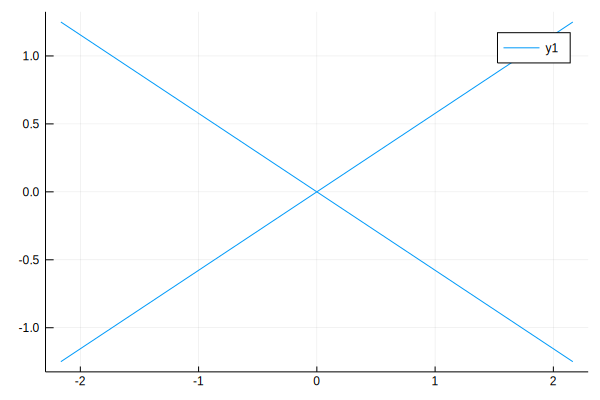

In [14]:
U = istieltjes(Φ)
plot(domain(U))

In [15]:
I + stieltjes(U,10.0) == Φ(10.0)

true

Thus we want to solve:

In [16]:
Φ((ζ)⁺) ≈ Φ((ζ)⁻)*G(ζ)
I + stieltjes(U,(ζ)⁺) ≈ (I + stieltjes(U,(ζ)⁻))*G(ζ)
stieltjes(U,(ζ)⁺) - stieltjes(U,(ζ)⁻)*G(ζ) ≈ G(ζ)-I
V = U*(-2π*im)
cauchy(V,(ζ)⁺) - cauchy(V,(ζ)⁻)*G(ζ) ≈ G(ζ)-I

true

We also have Plemelj that tells us ${\cal C}^+ -{\cal C^-} = I$, this changes (simplifies?) the equation to:

In [17]:
V(ζ) + cauchy(V,(ζ)⁻) - cauchy(V,(ζ)⁻)*G(ζ) ≈ G(ζ)-I
V(ζ)  - cauchy(V,(ζ)⁻)*(G(ζ)-I) ≈ G(ζ)-I

true

## Stieltjes transforms and OPs

The Stieltjes transform of weighted orthogonal polynomials 
satisfy the same recurrence as OPs themselves. 

We need to calculate Stieltjes transforms of OPs:

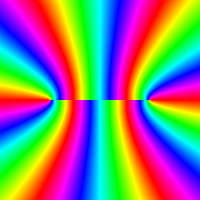

In [18]:
P = k -> Fun(Legendre(), [zeros(k);1])

xx = range(-2.,2.,length=200)
Z = xx' .+ im.*xx

portrait(stieltjes.(P(5), Z))

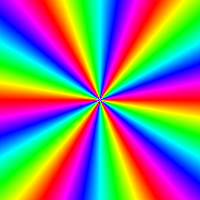

In [19]:
portrait(Z.^(-6))

Recall: the Jacobi operator is a tridiagonal operator that encodes multiplication by $x$:

In [20]:
x = Fun(Legendre())
J = Recurrence(Legendre())


f = Fun(exp, Legendre())
norm(J*f - x*f)

0.0

The Jacobi operator also encodes the three-term recurrence:

In [21]:
n=0
x*P(n) ≈ J[n+1,n+1]*P(n) + J[n+2,n+1]*P(n+1)


n=1
x*P(n) ≈ J[n,n+1]*P(n-1) + J[n+1,n+1]*P(n) + J[n+2,n+1]*P(n+1)


true

The Stieltjes transform satisfies the exact same recurrence for $n \geq 1$:

In [22]:
z = 1.0+2.0im
w = 1 # in general, the weight corresponding to OP
Q = (n,z) -> sum(P(n)*w/(z-x)) # sum means integral

n = 1
z*Q(n,z) ≈ J[n,n+1]*Q(n-1,z) + J[n+1,n+1]*Q(n,z) + J[n+2,n+1]*Q(n+1,z)

true

But not for $n = 0$:

In [23]:
n = 0
z*Q(n,z) ≈ J[n+1,n+1]*Q(n,z) + J[n+2,n+1]*Q(n+1,z)

false

But if we know `Q(0,z)` and `Q(1,z)` in closed form (We do!), we can calculate `Q` via recurrence. 

I like to represent this as a lower triangular operator:

In [24]:
L = z -> [BasisFunctional(1);
     BasisFunctional(2);
    SpaceOperator(transpose(J - z*I)[2:end,:],ℓ⁰,ℓ⁰)]
        
L(0)        

InterlaceOperator : SequenceSpace() → 3-element ArraySpace:
Space[ConstantSpace, ConstantSpace, SequenceSpace()]
 1.0                 0.0                  …  0.0                 ⋯
 0.0                 1.0                     0.0                 ⋱
 0.3333333333333333  0.0                     0.0                 ⋱
 0.0                 0.39999999999999997     0.0                 ⋱
 0.0                 0.0                     0.0                 ⋱
 0.0                 0.0                  …  0.0                 ⋱
 0.0                 0.0                     0.0                 ⋱
 0.0                 0.0                     0.0                 ⋱
 0.0                 0.0                     0.0                 ⋱
 0.0                 0.0                     0.5294117647058824  ⋱
  ⋮                   ⋱                   …   ⋱                  ⋱

In [25]:
μ₀ = stieltjes(P(0)*w,z)
μ₁ = stieltjes(P(1)*w,z)

n = 5
u = L(z)[1:n,1:n] \ [μ₀; μ₁; zeros(n-2)]

5-element Array{Complex{Float64},1}:
    0.34657359027997253 - 0.7853981633974483im   
   -0.08263008292513074 - 0.09225098283750298im  
   -0.02047897101517343 + 0.006432358667077497im 
 -0.0004860919654602121 + 0.0039580162862197284im
   0.000655510320055656 + 0.0004009376214656593im

This works great on or near the interval:

In [26]:
z = 0.1+eps()im

μ₀ = stieltjes(P(0)*w,z)
μ₁ = stieltjes(P(1)*w,z)

n = 100
u = L(z)[1:n,1:n] \ [μ₀; μ₁; zeros(n-2)]

100-element Array{Complex{Float64},1}:
  0.20067069546215124 - 3.1415926535897927im  
  -1.9799329304537843 - 0.3141592653589794im  
  -0.3973252872991432 + 1.5236724369910486im  
   1.2537344057526651 + 0.4633849164044942im  
   0.5173974864810735 - 1.0616619673724992im  
  -0.9098559770355384 - 0.561807087250645im   
   -0.597971501190743 + 0.7817203401477975im  
   0.6688247015236087 + 0.6267255665280007im  
   0.6486296950775765 - 0.5664942539053223im  
  -0.4719919033952208 - 0.66409386265145im    
  -0.6734451872149104 + 0.38366699461101433im 
   0.3005167400728086 + 0.6769672104725115im  
   0.6749237967942893 - 0.22194269638619826im 
                      ⋮                       
  0.14184941367271484 + 0.22634421744973532im 
  0.23805329322050453 - 0.11784046844462849im 
 -0.09292715409138425 - 0.24726644153539204im 
 -0.25392063603186216 + 0.06736395129918642im 
  0.04140894981448789 + 0.25797833139669324im 
  0.25942757082257345 - 0.015321337512756154im
  0.01064109831526331

In [27]:
stieltjes(P(n-1),z)-u[end]

2.7755575615628914e-17 + 1.1102230246251565e-16im

Note this is _much_ better than quadrature:

In [28]:
z=0.1+0.001im
@time μ=stieltjes(P(n-1),z)
@time sum(P(n-1)/(z-x))
@show abs(sum(P(n-1)/(z-x))-μ)
@time quadgk(x->P(n-1)(x)/(z-x),-1,1)
@show abs(quadgk(x->P(n-1)(x)/(z-x),-1,1)[1] - μ);

  0.000079 seconds (31 allocations: 6.375 KiB)
  0.067869 seconds (819 allocations: 24.827 MiB, 26.75% gc time)
abs(sum(P(n - 1) / (z - x)) - μ) = 4.392606376355813e-14
  1.357889 seconds (2.46 M allocations: 128.622 MiB, 5.79% gc time)
abs((quadgk((x->begin
                    #= In[28]:6 =#
                    (P(n - 1))(x) / (z - x)
                end), -1, 1))[1] - μ) = 4.3885418357208767e-16


Unfortunately, this breaks down for large $z$:

In [29]:
z = 100.0

μ₀ = stieltjes(P(0)*w,z)
μ₁ = stieltjes(P(1)*w,z)

n = 100
u = L(z)[1:n,1:n] \ [μ₀; μ₁; zeros(n-2)]

100-element Array{Float64,1}:
      0.020000666706669522  
      6.667066695240317e-5  
      2.6668952571412785e-7 
      1.142984085868605e-9  
      5.0707414099784735e-12
     -1.6538148987588797e-12
     -3.074250159474433e-10 
     -5.709179969175481e-8  
     -1.0704443445315075e-5 
     -0.002021899680293121  
     -0.38415130525659225   
    -73.33613836745825      
 -14055.741048399677        
      ⋮                     
     -3.9496900117655246e178
     -7.854805097786174e180 
     -1.5621944002918002e183
     -3.1071441442662403e185
     -6.180360461213906e187 
     -1.2293958060198338e190
     -2.445651787132766e192 
     -4.865438225763328e194 
     -9.679952785716854e196 
     -1.925963071583903e199 
     -3.8321776469863156e201
     -7.625455777961642e203 

In [30]:
stieltjes(P(n-1), z)

0.0

But note that the true stieltjes is in $\ell^2$:

In [31]:
[stieltjes(P(k), z) for k=0:100] |> norm

0.020000777828880434

Thus we can solve it using one boundary condition:

In [32]:
T = z -> [BasisFunctional(1);
    SpaceOperator(transpose(J - z*I)[2:end,:],ℓ⁰,ℓ⁰)]
T(z)

InterlaceOperator : SequenceSpace() → 2-element ArraySpace:
Space[ConstantSpace, SequenceSpace()]
 1.0                    0.0                  …     0.0                 ⋯
 0.3333333333333333  -100.0                        0.0                 ⋱
 0.0                    0.39999999999999997        0.0                 ⋱
 0.0                    0.0                        0.0                 ⋱
 0.0                    0.0                        0.0                 ⋱
 0.0                    0.0                  …     0.0                 ⋱
 0.0                    0.0                        0.0                 ⋱
 0.0                    0.0                        0.0                 ⋱
 0.0                    0.0                        0.5294117647058824  ⋱
 0.0                    0.0                     -100.0                 ⋱
  ⋮                      ⋱                   …      ⋱                  ⋱

In [38]:
z = 100.0

μ₀ = stieltjes(P(0)*w,z)        
        
n = 100
u = T(z)[1:n,1:n] \ [μ₀;zeros(n-1)]

100-element Array{Float64,1}:
 0.020000666706669522   
 6.667066695240317e-5   
 2.666895257144473e-7   
 1.1429841391064577e-9  
 5.080057794657254e-12  
 2.3091753139353408e-14 
 1.065800004129641e-16  
 4.973858189823564e-19  
 2.3406978482382525e-21 
 1.1087794019770231e-23 
 5.280034191637557e-26  
 2.525296987630347e-28  
 1.2121729040401978e-30 
 ⋮                      
 6.09287145569266e-206  
 3.0294922753741863e-208
 1.5064150369499735e-210
 7.491103591762882e-213 
 3.7253987099462816e-215
 1.852784717942273e-217 
 9.215138511587441e-220 
 4.583560451533549e-222 
 2.2799627188325937e-224
 1.1341636567013033e-226
 5.6421734618294046e-229
 2.806910415683975e-231 

In [39]:
norm(u - [stieltjes(P(k), z) for k=0:n-1])

5.739713219974347e-23

In practice, this can be determined adaptively using adaptive QR or F.W.J. Olver's algorithm (adaptive Gaussian elimination), but that's getting away.

Thus we have this algorithm:

1. If $z$ is close to $[-1,1]$ (where closed depends on $n$), solve a lower triangular system using forward recurrence.
2. If $z$ is far from $[-1,1]$, solve a tridiagonal system using adaptive QR.

## Dual numbers and "Log numbers"

We want to capture the behaviour of the singularities to set up a collocation system:

In [40]:
f = Fun(exp, -1..1)
stieltjes(f, 1.000001)

35.85252983289078

In [41]:
stieltjes(f, 1+0.000001im)

35.852495347781634 - 4.269828356622018im

The value has a "log part" which blows up, and a "finite part" that depends on the angle of approach. How do we represent this on a computer?

For inspiration, we use dual numbers:

In [42]:
x = dual(1,2)
cos(x)

0.5403023058681398 - 1.682941969615793ɛ

In [43]:
cos(1), -2sin(1)

(0.5403023058681398, -1.682941969615793)

In [44]:
cos(cos(x))

0.8575532158463934 + 0.8656973695406469ɛ

In [45]:
cos(cos(1)), 2sin(cos(1))*sin(1)

(0.8575532158463934, 0.8656973695406469)

This is _not_ numerical differentation: it is numerically stable.

In [46]:
# cos^n(x)
n = 100
ret = sin(x)
for k=1:n-1
    ret = sin(ret)
end
ret

0.16885248872798114 + 0.007397239571120209ɛ

In [47]:
dualpart(ret) - 2*0.0036986197855601063

-3.469446951953614e-18

The direction can be complex as well:

In [48]:
cos(dual(1.0,im))

0.5403023058681398 - 0.0im + 0.0ɛ - 0.8414709848078965imɛ

In [49]:
sqrt(dual(-1.0+0im,im))

0.0 + 1.0im + 0.5ɛ + 0.0imɛ

In [50]:
sqrt(dual(-1.0-0im,-im))

0.0 - 1.0im + 0.5ɛ + 0.0imɛ

In [51]:
log(dual(0.0,1.0))

Dual{Float64}(-Inf,Inf)

We use a dual-like number to annotate a number with a direction. When evaluated on a logarithmic singularity, it returns a "Log number", which represents local logarithmic behaviour of a function $f(z)$ by two numbers $a$ and $b$ so that
$$
f(c + hd) \sim a \log h + b
$$

In [52]:
log(RiemannDual(0.0,1.0))

(1.0 + 0.0im)log ε + 0.0 + 0.0im

In [53]:
l = log(RiemannDual(0.0,im))

(1.0 + 0.0im)log ε + 0.0 + 1.5707963267948966im

In [54]:
h = 0.00001
logpart(l)*log(h) + finitepart(l)

-11.512925464970229 + 1.5707963267948966im

In [55]:
l = stieltjes(f, RiemannDual(1.0,im))

l(h)

29.593415861168136 - 4.269867111336779im

In [56]:
stieltjes(f, 1.0 + im*h)

29.59345855815111 - 4.269542154749188im

## Zero-sum condition

When we have contours meeting at a junction, it's possible for the logarithmic singularities to cancel. This is the case if they satisfy the "zero-sum condition": that the values of the limits sum to zero. 

Here's a simple example of two contours who have 0 as a joint junction point:

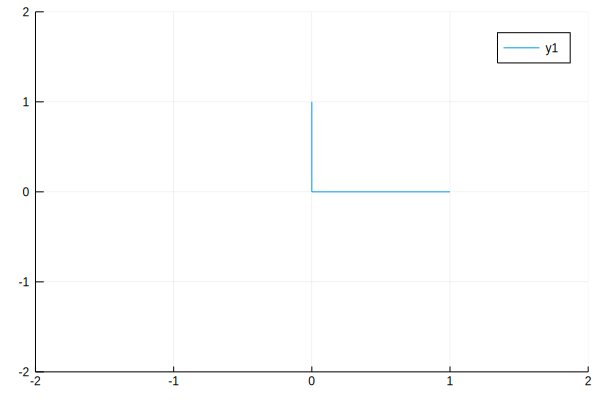

In [57]:
Γ = Segment(0,1) ∪ Segment(0, im)

plot(Γ;xlims=(-2,2),ylims=(-2,2))

And here's a function that satisfies the zero-sum condition:

In [58]:
f = Fun(z -> angle(z) == 0 ? exp(z) : -cos(abs(z)), Γ)
f₁, f₂ = pieces(f)
first(f₁) + first(f₂)

-5.551115123125783e-16 + 0.0im

It's Stieltjes transform does not blow up near zero:

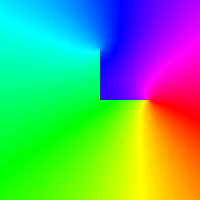

In [59]:
xx = range(-2,2,length=200)
Z = xx' .+ im*xx
portrait(stieltjes.(f,Z))

Each component has a logarithmic singularity:

In [60]:
stieltjes(f₁, -0.000001)

-15.133399294132499 + 0.0im

In [61]:
stieltjes(f₂, -0.000001)

13.575698815971109 + 1.5707948403214074im

But these are cancelled when summed together:

In [62]:
stieltjes(f, -0.000001)

-1.5577004781613901 + 1.5707948403214074im

This is easy to see with log numbers:

In [63]:
stieltjes(f₁, RiemannDual(0,-1))

(1.0000000000000007 + 0.0im)log ε + -1.3179021514543987 + 0.0im

In [64]:
stieltjes(f₂, RiemannDual(0,-1))

(-1.0000000000000013 + 0.0im)log ε + -0.23981174200057068 + 1.5707963267948988im

In [65]:
stieltjes(f, RiemannDual(0,-1))

(-6.661338147750939e-16 + 0.0im)log ε + -1.5577138934549695 + 1.5707963267948988im

The value still depends on the angle:

In [66]:
finitepart(stieltjes(f,RiemannDual(0,1+im))),
    finitepart(stieltjes(f,RiemannDual(0,-1+im)))

(-1.5577138934549697 - 4.712388980384695im, -1.5577138934549697 + 1.5707963267948983im)

## Product condition and cyclic junction condition

Now consider a Riemann–Hilbert problem which satisfies the _product condition_. That is, the product of the jumps is I:

In [67]:
G₁, G₂, G₃, G₄ = first.(pieces(G))

G₄*G₃*G₂*G₁

2×2 Array{Complex{Float64},2}:
          1.0+0.0im  6.84142e-18+0.0im
 -6.84142e-18+0.0im          1.0+0.0im

The _cyclic junction condition_ is a property satisfied by the right-hand side:

In [68]:
F = G-I
F₁, F₂, F₃, F₄ = first.(pieces(F))

F₁*G₂*G₃*G₄ + F₂*G₃*G₄ + F₃*G₄ + F₄   |> norm

9.675222525179979e-18

This is due to a telescoping sum argument. In general, any function `U` that satisfies the zero sum condition has the property that $(I - (G-I)C^-) U $ satisfies the cyclic junction condition.


Zero-sum condition also gets us continuity in each sector:

In [69]:
z₁, z₂, z₃, z₄ = exp(π*im/6), exp(5π*im/6), exp(-5π*im/6), exp(-π*im/6)

U = istieltjes(Φ)
U₁, U₂, U₃, U₄ = pieces(U)

C₁₊, C₂₊, C₃₊, C₄₊ = finitepart.(
        stieltjes(U₁,RiemannDual(0,z₁)⁺) +
            stieltjes(U₂,RiemannDual(0,z₁)) +
            stieltjes(U₃,RiemannDual(0,z₁)) +
            stieltjes(U₄,RiemannDual(0,z₁))  
        ) ,
        finitepart.(
        stieltjes(U₁,RiemannDual(0,z₂)) +
            stieltjes(U₂,RiemannDual(0,z₂)⁺) +
            stieltjes(U₃,RiemannDual(0,z₂)) +
            stieltjes(U₄,RiemannDual(0,z₂))  
        ) ,
        finitepart.(
        stieltjes(U₁,RiemannDual(0,z₃)) +
            stieltjes(U₂,RiemannDual(0,z₃)) +
            stieltjes(U₃,RiemannDual(0,z₃)⁺) +
            stieltjes(U₄,RiemannDual(0,z₃))  
        ) ,
        finitepart.(
        stieltjes(U₁,RiemannDual(0,z₄)) +
            stieltjes(U₂,RiemannDual(0,z₄)) +
            stieltjes(U₃,RiemannDual(0,z₄)) +
            stieltjes(U₄,RiemannDual(0,z₄)⁺)  
        ) 

C₁₋, C₂₋, C₃₋, C₄₋ = finitepart.(
            stieltjes(U₁,RiemannDual(0,z₁)⁻) +
            stieltjes(U₂,RiemannDual(0,z₁)) +
            stieltjes(U₃,RiemannDual(0,z₁)) +
            stieltjes(U₄,RiemannDual(0,z₁))  
        ) ,
        finitepart.(
            stieltjes(U₁,RiemannDual(0,z₂)) +
            stieltjes(U₂,RiemannDual(0,z₂)⁻) +
            stieltjes(U₃,RiemannDual(0,z₂)) +
            stieltjes(U₄,RiemannDual(0,z₂))  
        ) ,
        finitepart.(
            stieltjes(U₁,RiemannDual(0,z₃)) +
            stieltjes(U₂,RiemannDual(0,z₃)) +
            stieltjes(U₃,RiemannDual(0,z₃)⁻) +
            stieltjes(U₄,RiemannDual(0,z₃))  
        ) ,
        finitepart.(
            stieltjes(U₁,RiemannDual(0,z₄)) +
            stieltjes(U₂,RiemannDual(0,z₄)) +
            stieltjes(U₃,RiemannDual(0,z₄)) +
            stieltjes(U₄,RiemannDual(0,z₄)⁻)  
        ) ;


norm(C₁₊ - C₂₋)

6.214465357936134e-16

Thus combined with the cyclical jump condition, we satisfy the jumps:

In [70]:
C₄₊ ≈ C₄₋*G₄ + F₄
C₄₊ ≈ C₃₊*G₄ + F₄
C₄₊ ≈ C₃₋*G₃*G₄ + F₃*G₄ + F₄
C₄₊ ≈ C₂₊*G₃*G₄ + F₃*G₄ + F₄
C₄₊ ≈ C₁₊*G₂*G₃*G₄ + F₂*G₃*G₄ + F₃*G₄ + F₄
C₄₊ ≈ C₁₋*G₁*G₂*G₃*G₄ + F₁*G₂*G₃*G₄ + F₂*G₃*G₄ + F₃*G₄ + F₄

true

In [71]:
norm( F₁*G₂*G₃*G₄ + F₂*G₃*G₄ + F₃*G₄ + F₄)

9.675222525179979e-18

## 2017 v 2023    (Future directions.)


President Ivanka Trump.... 😰





#### Banded operators

Chebyshev singularities lead to banded operators:

In [72]:
H = Hilbert() : ChebyshevWeight(Segment(-1,1),0)

HilbertWrapper : (1-x^2)^-0.5[Chebyshev(the segment [-1.0,1.0])] → Ultraspherical(1,the segment [-1.0,1.0])
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ⋯
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ⋱
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ⋱
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ⋱
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ⋱
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ⋱
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ⋱
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ⋱
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ⋱
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ⋱
  ⋮    ⋱    ⋱    ⋱    ⋱    ⋱    ⋱    ⋱    ⋱    ⋱   ⋱

Thus $ I - (G-I)C^-$ can be represented on a single interval when $G$ has appropriate decay to 1:

In [73]:
G̃ = Fun(x->exp(-40x^2),ChebyshevWeight(Segment(-1,1),0))
G = Fun(x->1+exp(-40x^2),Chebyshev())
(I+G)/2 + im/2*G̃*H

PlusOperator : (1-x^2)^-0.5[Chebyshev(the segment [-1.0,1.0])] → (1-x^2)^-0.5[Ultraspherical(1,the segment [-1.0,1.0])]
   1.0886432670340571 + 0.0im  …  ⋯
                  0.0 + 0.0im     ⋱
 -0.08426795592489292 + 0.0im     ⋱
                  0.0 + 0.0im     ⋱
   0.0761649869582432 + 0.0im     ⋱
                  0.0 + 0.0im  …  ⋱
 -0.06546994432074481 + 0.0im     ⋱
                  0.0 + 0.0im     ⋱
 0.053542023442444714 + 0.0im     ⋱
                  0.0 + 0.0im     ⋱
                       ⋮       …  ⋱

How to do this with junctions?

#### Hierarchical structure

Stieltjes transforms have low rank structure when evaluated off the interval:

In [74]:
Fun(z -> stieltjes(P(15),z), Legendre(Segment(1+im,2+2im))) |>norm

8.244707787129414e-9

In [64]:
K = LowRankFun((z,ζ) -> 1/(z-ζ), Legendre()*Legendre(Segment(1+im,2+2im)))

rank(K)

12

This is exactly the sort of structure that makes Fast Multipole Method / Hierarchical matrices fast.  We can exploit this by plugging in RiemannHilbert.jl into HierarchicalMatrices.jl.